# 用机器学习做个艺术画家-Prisma(中) 

作者：阿布🐶

微信：aaaabbbuu

未经本人允许禁止转载

上一章使用的两种方式实现prisma，都存在问题，这章要使用的方式是我自己原创的方法，我实际上并不知道prisma到底使用了什么方式使图像效果又好，速度又快，但是大概猜测的方向也就这几种可能：

1. 大量的多cpu，gpu的机器（绝对不现实，成本根本无法控制）
2. 优化算法，优化网络框架（就算是这样，我没能力在这方面优化🙈）
3. 拥有很大的图像数据库，可以很快的检索出与输入图像相似度最高的图像，之后相似特征提取权重渲染（我没资源，而且这种方式的瓶颈在检索和相似度计算上也很消耗资源，只是一种可能）
4. 针对图像部分使用机器学习算法特征层放大，部分使用一些图像处理技术，提升渲染速度

我下面讲的内容是针对第四点展开试验的，可以在速度及渲染效果上都能达到比较满意的效果，因为速度上可以忽略，效果还挺好，唯一的缺陷就是在适用性上可能会需要调整一下参数（在适用性上可以结合上述第三种方式，针对一定数量的样本作为训练集x，对应的y是效果参数，对输入进行分类，再配合使用相似度等提高自动适配的能力）



[项目git地址](https://github.com/bbfamily/prisma_abu)

### 1 主要实现思路分解讲解

我还是使用abu1这张图片作为输入

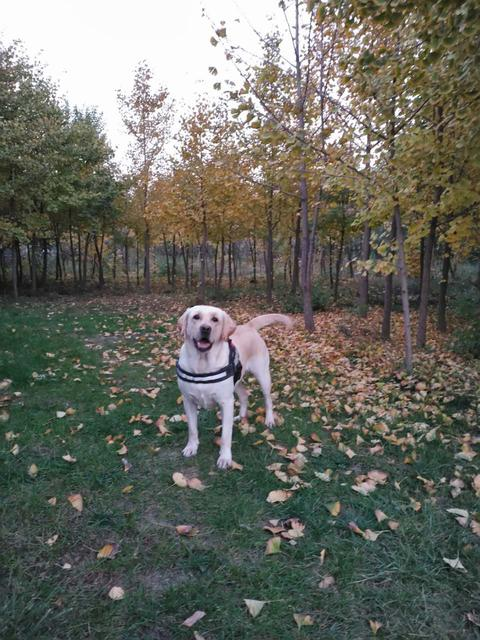

In [1]:
from __future__ import division
import matplotlib.pylab as plt
%matplotlib inline

import os
from PrismaCaffe import CaffePrismaClass
import PrismaHelper
import glob
import numpy as np
import PIL.Image
import ZCommonUtil
import itertools
from functools import partial
abu1_file = '../sample/abu1.jpg'
cp  = CaffePrismaClass(dog_mode=False)
PrismaHelper.show_array_ipython(np.float32(cp.resize_img(PIL.Image.open(abu1_file))))

然后挑一张引导特征图像

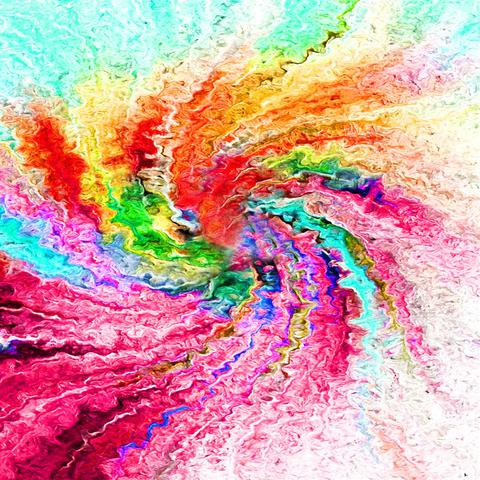

In [4]:
gd_path = '../prisma_gd/tooopen_sy_127260228921.jpg'
guide_img = np.float32(cp.resize_img(PIL.Image.open(gd_path), base_width=480, keep_size=False))
PrismaHelper.show_array_ipython(guide_img)

导入一些相关图像处理的基础包

In [5]:
from skimage import filters
from skimage import segmentation
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from scipy.signal import convolve2d
from scipy import ndimage
from scipy import misc

如下图所示，首先将图像转化为单通道，用otsu寻找mask, 通过mask确定border和edges 

备注：

otsu(大津算法, 自适应阈值)

* [关于skimage otsu等使用请参考](http://scikit-image.org/)

* [关于scipy ndimage等使用请参考](https://docs.scipy.org)

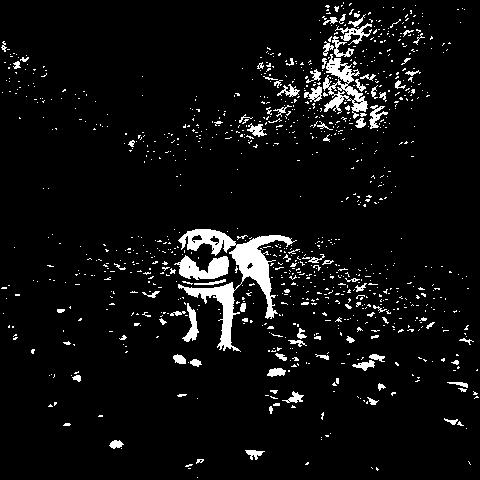

In [13]:
r_img = cp.resize_img(PIL.Image.open(abu1_file), base_width=480, keep_size=False)
# rgb转化为单通道灰阶图像
l_img = np.float32(r_img.convert('L'))
# filters.threshold_otsu需要－1， 1之间
l_img = np.float32(l_img / 255) 
r_img = np.float32(r_img)

# 找出大于otsu的阀值作为mask，需找border
mask = l_img > filters.threshold_otsu(l_img)
# 不是适用所有图像都要clear border，比如图像主题大部分是需要保留就不需要
clean_border = segmentation.clear_border(mask).astype(np.int)
coins_edges = segmentation.mark_boundaries(l_img, clean_border)
# 将值再次转换到0-255
clean_border_img = np.float32(clean_border * 255)
clean_border_img = np.uint8(np.clip(clean_border_img, 0, 255))

PrismaHelper.show_array_ipython(clean_border_img)

目标就是只想摘取阿布的图像，其它的都认为是噪音，可以使用如下ndimage.binary_opening达到效果吗，试试看

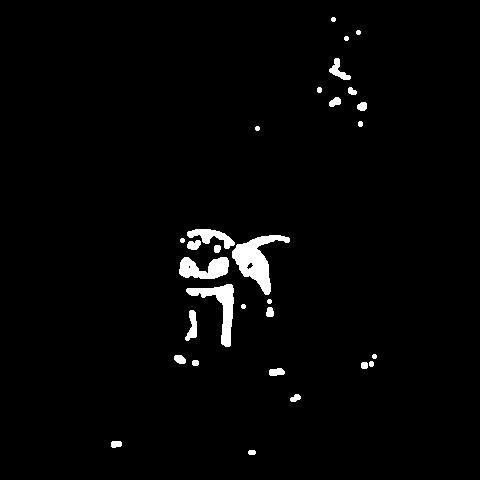

In [15]:
clean_border_img = ndimage.binary_opening(np.float32(clean_border_img / 255), structure=np.ones((5,5))).astype(np.int)
clean_border_img = ndimage.binary_opening(clean_border_img).astype(np.int)
PrismaHelper.show_array_ipython(clean_border_img * 255)

效果其实不太好，ndimage.binary_opening效果与cnn中的最小池化层相似，目的就是remove small object，我们下面通过自定义简单卷积核来过滤，实现我们的需求，代码如下

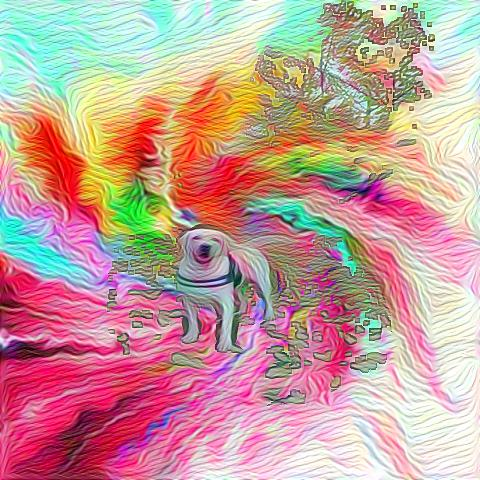

In [27]:
# 最小的卷积核目的是保留大体图像结构
n= 5
small_window = np.ones((n, n))
small_window /= np.sum(small_window)
clean_border_small = convolve2d(clean_border_img, small_window, mode="same", boundary="fill")

# 中号的卷积核是为了保留图像的内嵌部分，这里的作用就是阿布的黑鼻子和嘴那部分，如果没有这层，就无法保留
n= 25
median_window = np.ones((n, n))
median_window /= np.sum(median_window)
clean_border_convd_median = convolve2d(clean_border_img, median_window, mode="same", boundary="fill")

# 最大号的卷积核，只是为了去除散落的边缘，很多时候没有必要，影响速度和效果
n= 180
big_window = np.ones((n, n))
big_window /= np.sum(big_window)
clean_border_convd_big = convolve2d(clean_border_img, big_window, mode="same", boundary="fill")

l_imgs = []
for d in range(3):
    # 分别对rgb三个通道进行滤波
    rd_img = r_img[:,:,d]
    gd_img = guide_img[:,:,d]
    # 符合保留条件的使用原始图像，否则使用特征图像
    d_img = np.where(np.logical_or(clean_border_convd_median > 5 * clean_border_convd_big.mean(), 
            np.logical_and(clean_border_small > 0, clean_border_convd_big > 2 * clean_border_convd_big.mean())), 
            rd_img, gd_img)
    l_imgs.append(d_img)
img_cvt = np.stack(l_imgs, axis=2).astype("uint8")
# 对转换出的图像进行一次简单浅层特征放大
d_img = cp.fit_img(nbk='conv2/3x3_reduce', iter_n=10, img_np=img_cvt)
PrismaHelper.show_array_ipython(np.float32(d_img))

代码并不多，主要思路如下：

1. 通过filters.threshold_otsu找出图像的mask
2. segmentation.clear_border(mask)抽取图像border, edges
3. 使用三个卷积核对图像进行滤波处理，这里的三个卷积核的分工请看上面代码注释，这里的滤波是就是引导特征和原始图像的权重分配

卷积的意义简单理解就是**加权叠加**, 针对输入的单位相应得到输出，为什么要用卷积呢，其实就是为了效率，如果上面的代码你从目的出发，知道要滤除什么样的像素点，保留什么样的像素点，使用for循环针对每一个像素点，计算像素点一定范围内（上面说的核大小）使用for循环一步一步的前进，你其实也能得出结果，但是运算的时间复杂度将大出几个数量级，这就类似很多最优问题你可以使用蒙特卡洛方法求最优解，但是由于计算量太大，实际上无法做到遍历所有路径，所以才会使用凸优化等数学方式求最优解，并且很多时候也是先求个大概的全局最优，然后在这个全局最优的基础上求解局部最优解。

### 2. 使用图像特征作为mask

上面的方法使用otsu寻找图像边缘作为mask的依据，下面我使用skimage中的corner_peaks抽取**图像特征**作为mask

In [6]:
def show_features(gd_file):
    r_img = cp.resize_img(PIL.Image.open(gd_file), base_width=480, keep_size=False)
    l_img = np.float32(r_img.convert('L'))
    ll_img = np.float32(l_img / 255)
    
    coords = corner_peaks(corner_harris(ll_img), min_distance=5)
    coords_subpix = corner_subpix(ll_img, coords, window_size=25)

    plt.figure(figsize=(8, 8))
    plt.imshow(r_img, interpolation='nearest')
    plt.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15, mew=5)
    plt.plot(coords[:, 1], coords[:, 0], '.b', markersize=7)
    plt.axis('off')
    plt.show()
    
def find_features(gd_file=None, r_img=None, l_img=None, loop_factor=1, show=False):
    if gd_file is not None:
        r_img = cp.resize_img(PIL.Image.open(gd_file), base_width=480, keep_size=False)
        l_img = np.float32(r_img.convert('L'))
        l_img = np.float32(l_img / 255)
    
    coords = corner_peaks(corner_harris(l_img), min_distance=5)
    coords_subpix = corner_subpix(l_img, coords, window_size=25)
    
    r_img_copy = np.zeros_like(l_img)
    rd_img = np.float32(r_img)

    r_img_copy[coords[:, 0], coords[:, 1]] = 1
    
    f_loop = int(rd_img.shape[1]/10 * loop_factor)
    for _ in np.arange(0, f_loop):
        """
            放大特征点，使用loop_factor来控制特征放大倍数
        """
        r_img_copy = ndimage.binary_dilation(r_img_copy).astype(r_img_copy.dtype)
    r_img_copy_ret = r_img_copy * 255
    
    if show:
        r_img_copy_d = [rd_img[:,:,d] * r_img_copy for d in range(3)]
        r_img_copy = np.stack(r_img_copy_d, axis=2)
        PrismaHelper.show_array_ipython(r_img_copy) 
    return r_img_copy_ret

如下显示的图抽取出图像特征点

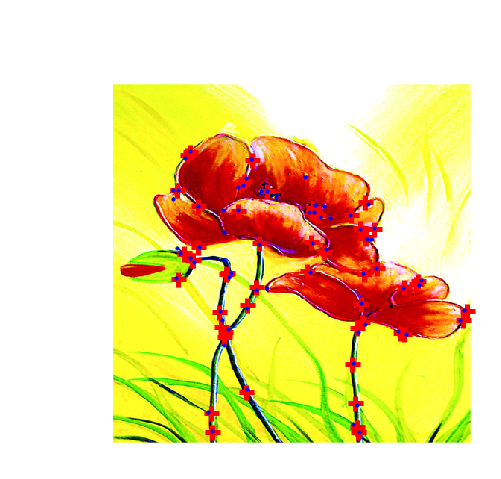

In [7]:
show_features('../prisma_gd/71758PICxSa_1024.jpg')

find_features使用ndimage.binary_dilation来**放大**特征点，使用loop_factor来控制特征放大倍数，目的是结合引导特征做渲染时提升原始图像的特征权重，如下所示find_features提取后的结果

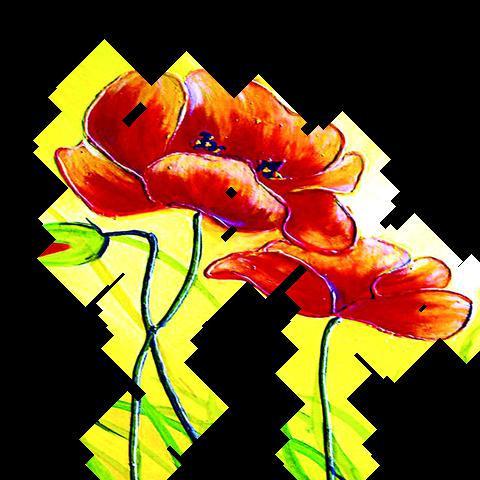

In [49]:
_ = find_features('../prisma_gd/71758PICxSa_1024.jpg', loop_factor=1, show=True)

下面用ipython notebook的可交互形式更直观的看一下特征的抽取与放大

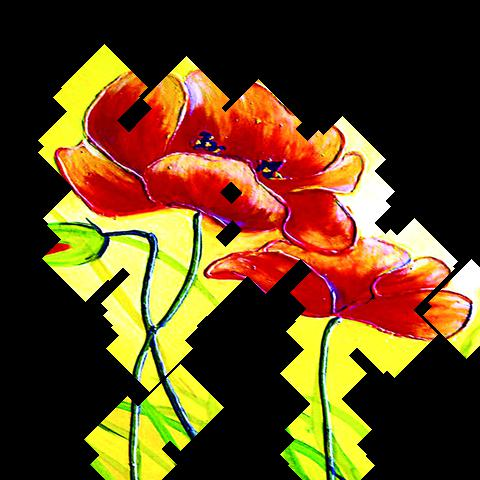

<function __main__.find_features_interact>

In [8]:
from ipywidgets import interact
def find_features_interact(gd_file, loop_factor):
    r_img = cp.resize_img(PIL.Image.open(gd_file), base_width=480, keep_size=False)
    l_img = np.float32(r_img.convert('L'))
    l_img = np.float32(l_img / 255)
    
    coords = corner_peaks(corner_harris(l_img), min_distance=5)
    coords_subpix = corner_subpix(l_img, coords, window_size=25)
    
    r_img_copy = np.zeros_like(l_img)
    rd_img = np.float32(r_img)

    r_img_copy[coords[:, 0], coords[:, 1]] = 1
    
    f_loop = int(rd_img.shape[1]/10 * loop_factor)
    for _ in np.arange(0, f_loop):
        """
            放大特征点，使用loop_factor来控制特征放大倍数
        """
        r_img_copy = ndimage.binary_dilation(r_img_copy).astype(r_img_copy.dtype)
    r_img_copy_ret = r_img_copy * 255
    
    r_img_copy_d = [rd_img[:,:,d] * r_img_copy for d in range(3)]
    r_img_copy = np.stack(r_img_copy_d, axis=2)
    PrismaHelper.show_array_ipython(r_img_copy) 
gd_file = ('../prisma_gd/71758PICxSa_1024.jpg', '../prisma_gd/st.jpg', '../prisma_gd/g1.jpg', '../prisma_gd/31K58PICSuH.jpg')
loop_factor = (0, 2, 0.1)
interact(find_features_interact, gd_file=gd_file, loop_factor=loop_factor)

如果不是使用ipython notebook版本的可以下载gif看效果 [下载地址](https://github.com/bbfamily/monitor_parallel/blob/master/ft.gif)

### 3. 使用统计参数期望与标准差寻找mask

mask的抽取方法可以有很多种方式，比如我下面这股票量化统计中经常使用的均值回复分析，使用图像的均值和标准差来做滤波器，提取图像的mask
下图是股票量化中均值回复策略图，对股票量化感兴趣的可以看我之前的文章[打开股票量化的黑箱](http://www.jianshu.com/p/4ba3a10ea9e5)

下面我们重构一下代码，分别使用三种滤波图像的方式生成mask查看效果

1. def do_otsu(r_img, l_img, cb)(最开始介绍的方式的代码封装)
2. def do_features(r_img, l_img, cb, loop_factor=1.0)(上面介绍的那种抽取图像点集特征放大的方式)
3. def do_stdmean(r_img, l_img, cb, std_factor=1.0): (均值标准差统计方式抽取mask)

![](../show/output_23_0.png)

### 4. 使用多种方式prisma图像

In [28]:
def do_otsu(r_img, l_img, cb, dd=True):
    mask = l_img > filters.threshold_otsu(l_img) if dd else l_img < filters.threshold_otsu(l_img)
    clean_border = mask
    if cb:
        clean_border = segmentation.clear_border(mask).astype(np.int)
    clean_border_img = np.float32(clean_border * 255)
    clean_border_img = np.uint8(np.clip(clean_border_img, 0, 255))
    return clean_border_img

def do_features(r_img, l_img, cb, loop_factor=1.0):
    mask = find_features(r_img=r_img, l_img=l_img, loop_factor=loop_factor)
    clean_border = mask
    if cb:
        clean_border = segmentation.clear_border(mask).astype(np.int)
    clean_border_img = np.float32(clean_border * 255)
    clean_border_img = np.uint8(np.clip(clean_border_img, 0, 255))
    return clean_border_img


"""
    可以结合上面股票的图感受一下图像滤波的部分
"""
def do_stdmean(r_img, l_img, cb, std_factor=1.0):
    mean_img = l_img.mean()
    std_img = l_img.std()
    
    mask1 = l_img > mean_img + (std_img * std_factor)
    mask2 = l_img < mean_img - (std_img * std_factor)
    
    clean_border = mask1
    if cb:
        clean_border = segmentation.clear_border(mask1).astype(np.int)
    clean_border_img1 = np.float32(clean_border * 255)
    clean_border_img1 = np.uint8(np.clip(clean_border_img1, 0, 255))
    
    clean_border = mask2
    if cb:
        clean_border = segmentation.clear_border(mask2).astype(np.int)
    clean_border_img2 = np.float32(clean_border * 255)
    clean_border_img2 = np.uint8(np.clip(clean_border_img2, 0, 255))
    
    # 上下两部分组合
    clean_border_img = clean_border_img1 + clean_border_img2
    clean_border_img = np.uint8(np.clip(clean_border_img, 0, 255))
    
    return clean_border_img

"""
    将多个mask func组合与的形式，组合mask滤波器
    exp: tgt_mask_func = partial(together_mask_func, func_list=[do_otsu, mask_stdmean_func, mask_features_func])
"""
def together_mask_func(r_img, l_img, cb, func_list):
    clean_border_img = None
    for func in func_list:
        if not callable(func):
            raise TypeError("together_mask_func must a func!!!")
        border_img = func(r_img, l_img, cb)
        if clean_border_img is None:
            clean_border_img = border_img
        else:
            clean_border_img = clean_border_img + border_img
    clean_border_img = np.uint8(np.clip(clean_border_img, 0, 255))
    return clean_border_img
    
    
"""
    使用partial统一mask函数接口形式
"""
mask_stdmean_func = partial(do_stdmean, std_factor=1.0)
mask_features_func = partial(do_features, loop_factor=0.88)

def do_convd_filter(n1, n2, n3, rb_rate, r_img, guide_img, clean_border_img, convd_median_factor, convd_big_factor):
    n= n1
    small_window = np.ones((n, n))
    small_window /= np.sum(small_window)
    clean_border_small = convolve2d(clean_border_img, small_window, mode="same", boundary="fill")

    n= n2
    median_window = np.ones((n, n))
    median_window /= np.sum(median_window)
    clean_border_convd_median = convolve2d(clean_border_img, median_window, mode="same", boundary="fill")

    n= n3
    big_window = np.ones((n, n))
    big_window /= np.sum(big_window)
    clean_border_convd_big = convolve2d(clean_border_img, big_window, mode="same", boundary="fill")

    l_imgs = []
    for d in range(3):
        """
            针对rgb各个通道处理
        """
        rd_img = r_img[:,:,d]
        gd_img = guide_img[:,:,d]
        
        wn = []
        for _ in np.arange(0, rd_img.shape[1]):
            """
                二项式概率分布
            """
            wn.append(np.random.binomial(1, rb_rate, rd_img.shape[0]))
        if rb_rate <> 1:
            """
                针对rgb通道阶梯下降二项式概率
            """
            rb_rate = rb_rate - 0.1
        w = np.stack(wn, axis=1)

        d_img = np.where(np.logical_or(
                         np.logical_and(clean_border_convd_median > convd_median_factor * clean_border_convd_big.mean(), w == 1),
                         np.logical_and(np.logical_and(clean_border_small > 0, w == 1), 
                                        clean_border_convd_big > convd_big_factor * clean_border_convd_big.mean(), 
                                        )), 
                         rd_img, gd_img)
    
        l_imgs.append(d_img)
    img_cvt = np.stack(l_imgs, axis=2).astype("uint8")
    return img_cvt
    
def mix_mask_with_convd(do_mask_func, org_file=None, gd_file=None, nbk=None, enhance=None, n1=5, n2=38, n3=1, 
                        convd_median_factor=5.0, convd_big_factor=0.0, cb=False, 
                        rb_rate=1, r_img=None, guide_img=None, all_mask=False, show=False):
    if r_img is None:
        r_img = cp.resize_img(PIL.Image.open(org_file), base_width=480, keep_size=False)
        
    l_img = np.float32(r_img.convert('L'))
    l_img = np.float32(l_img / 255) 
    r_img = np.float32(r_img)
    
    if show:
        PrismaHelper.show_array_ipython(np.float32(r_img))
        
    if not callable(do_mask_func):
        raise TypeError('mix_mask_with_convd must do_mask_func a func')

    clean_border_img = np.ones_like(l_img) * 255 if all_mask else do_mask_func(r_img=r_img, l_img=l_img, cb=cb)

    if show:
        PrismaHelper.show_array_ipython(np.float32(clean_border_img))
    
    if guide_img is None:
        if gd_file is not None:
            guide_img = np.float32(cp.resize_img(PIL.Image.open(gd_file), base_width=480, keep_size=False))
        else:
            guide_img = np.zeros_like(r_img)

    img_cvt = do_convd_filter(n1, n2, n3, rb_rate, r_img, guide_img, clean_border_img, 
                              convd_median_factor=convd_median_factor, convd_big_factor=convd_big_factor)
        
    if nbk is not None:
        img_cvt = cp.fit_img(org_file, nbk=nbk, iter_n=10, enhance=enhance, img_np=img_cvt)
    
    if show:
        PrismaHelper.show_array_ipython(np.float32(img_cvt))
    return img_cvt

如下使用特征do_features mask方式，注意rb_rate=0.66的使用，这里使用它目的是使**特征边缘平滑过渡**到引导特征中, 当然这里还可以有各种优化方式，比如向下调整convd_median_factor使原始特征边缘提取更加圆润平滑

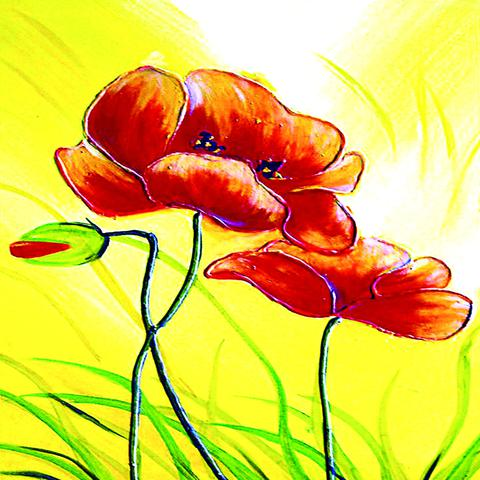

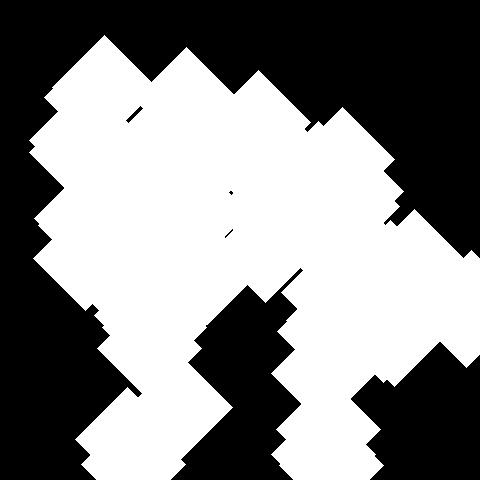

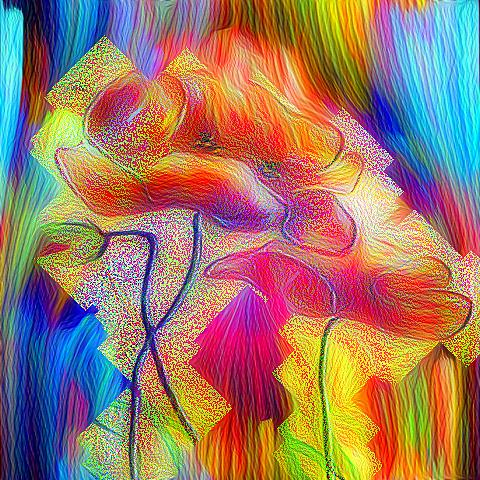

In [23]:
_ = mix_mask_with_convd(partial(do_features, loop_factor=1.1), '../prisma_gd/71758PICxSa_1024.jpg', 
                        '../prisma_gd/cx6.jpg', 'conv2/3x3_reduce', rb_rate=0.66, show=True)

如下库日天这张图使用均值回复mask方式可以对图片产生比较好的效果，使用其它两种效果均不佳，读者可自行测试

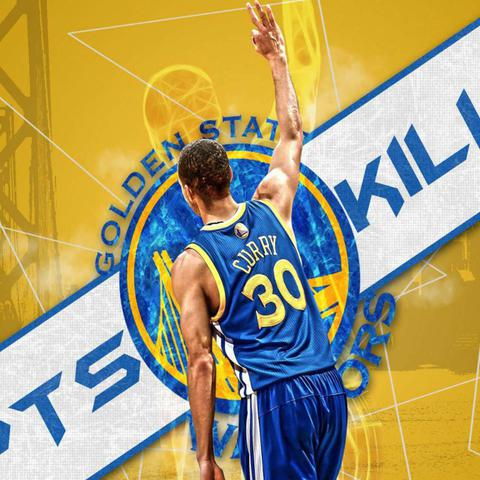

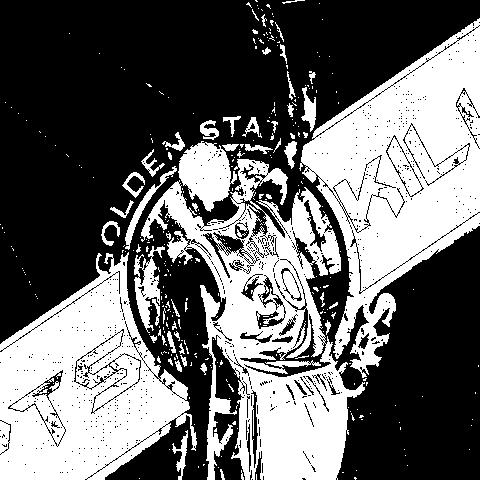

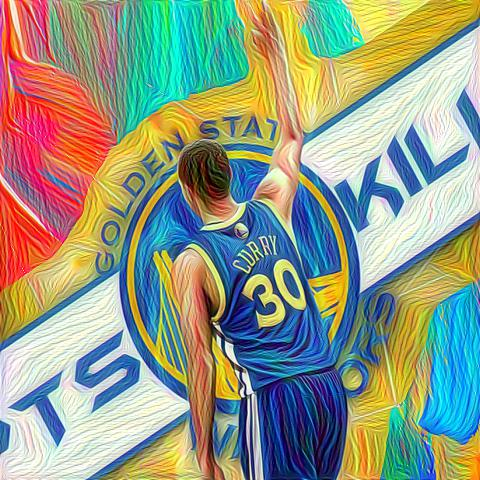

In [59]:
_ = mix_mask_with_convd(mask_stdmean_func, '../sample/kl.jpg', '../prisma_gd/cx7.jpg', 'conv2/3x3_reduce', 
                        n2=88, convd_median_factor=0.1, rb_rate=1, show=True)


使用abu2看看现在的方式的运行效率，%time计算一下耗时，请注意参数，n3=1，convd_median_factor=0.2, convd_big_factor=0.0
也就是不使用最大的卷积核了，速度会非常快, 只用了5.62 s，而且这个速度还是做了一些其它工作，如显示原图等工作的情况下

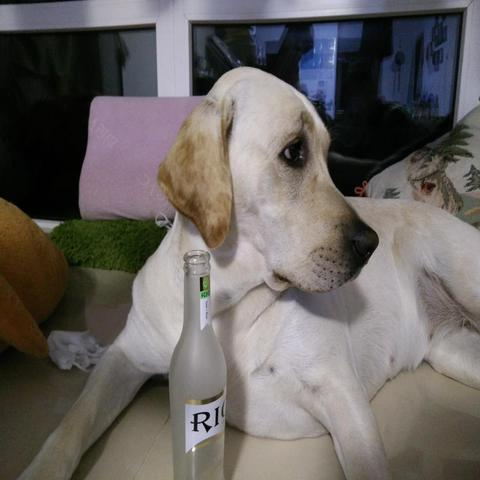

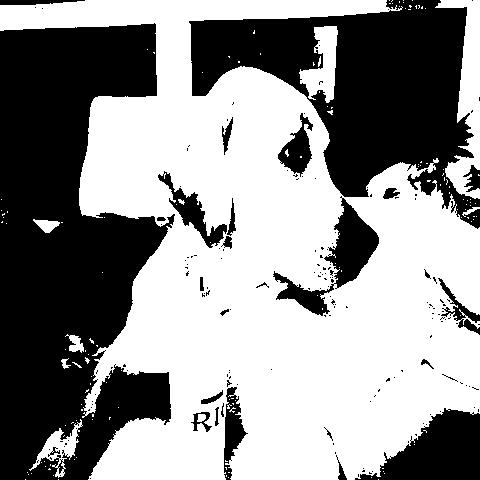

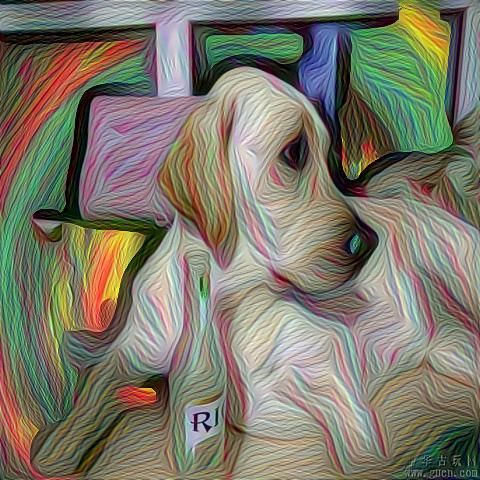

CPU times: user 5.62 s, sys: 99.4 ms, total: 5.71 s
Wall time: 4.2 s


In [29]:
%time _ = mix_mask_with_convd(do_otsu, '../sample/abu2.jpg', '../prisma_gd/k5.jpg', 'conv2/3x3_reduce', n3=1, \
                        convd_median_factor=0.2, convd_big_factor=0.0, show=True)

abu5使用partial(together_mask_func, func_list=[do_otsu, mask_features_func]), 组合多个特征抽取mask函数，多个滤波函数以'与的关系'进行组合，对图像进行mask，这里如果不是用together_mask_func的话，单独每个都要再次调整一些参数，比如单独使用do_otsu，要调大n2核的大小，影响速度，mask函数合并特征完美快速实现了需求

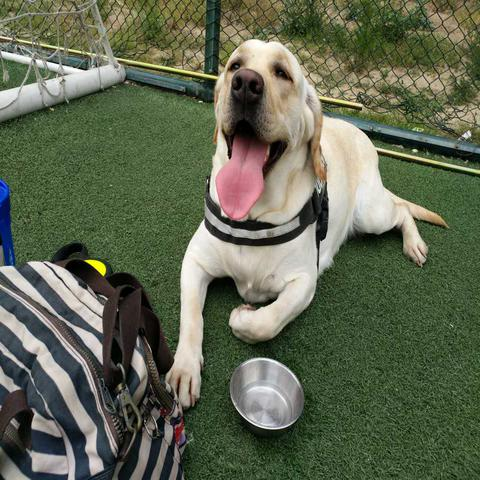

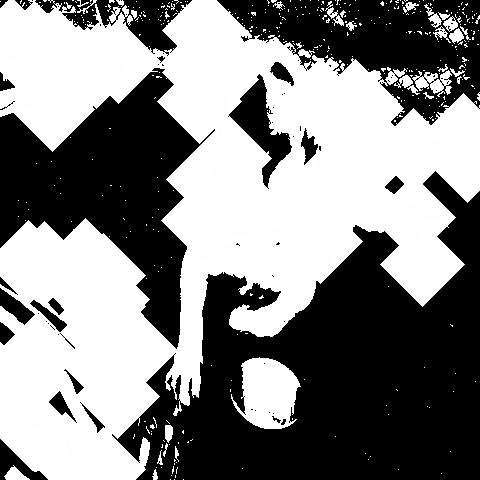

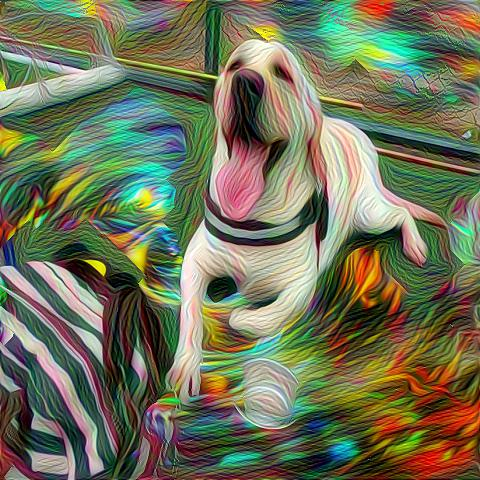

In [73]:
tgt_mask_func = partial(together_mask_func, func_list=[do_otsu, mask_features_func])
_ = mix_mask_with_convd(tgt_mask_func, '../sample/abu3.jpg', '../prisma_gd/cx3.jpg', 'conv2/3x3_reduce', cb=False, 
                        n2=68, n3=1, convd_median_factor=1, convd_big_factor=0.0, show=True)

### 5. 配合使用预处理图像增强，随机rgb浅层edges等增强prisma效果

一生的偶像艾弗森，使用**图像预处理**的方式来做图，首先用Contrast看看，注意这里设置了参数rb_rate=0.88，看代码它的作用是

        wn = []
        for _ in np.arange(0, rd_img.shape[0]):
            wn.append(np.random.binomial(1, rb_rate, rd_img.shape[1]))
        if rb_rate <> 1:
            rb_rate = rb_rate - 0.1
        w = np.stack(wn, axis=1)
        
		d_img = np.where(np.logical_or(
		         np.logical_and(clean_border_convd_median > convd_median_factor * clean_border_convd_big.mean(), w == 1),
		         np.logical_and(np.logical_and(clean_border_small > 0, w == 1), 
		                        clean_border_convd_big > convd_big_factor * clean_border_convd_big.mean(), 
		                        )), 
		         rd_img, gd_img)
        
* 逻辑和中np.logical_and添加w == 1的判断， 这里使用二项式分布，增强渲染的迷幻效果，即随机在rgb某一个通道中渲染一下引导特征
* rb_rate = rb_rate - 0.1 的作用是3个通道的随机渲染概率阶梯下降, 这里也可以有其它各种渲染变种

再具体形象点举例这里的w二项式分布矩阵就类似下面这个示例矩阵所示，0.8的概率为1
针对图像中每一个像素点

In [4]:
wn = []
for _ in np.arange(0, 20):
    wn.append(np.random.binomial(1, 0.8, 20))
w = np.stack(wn, axis=1)
w

array([[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1],
       [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1],
       [1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
       [1, 0, 0, 1, 1, 0, 1, 1, 1,

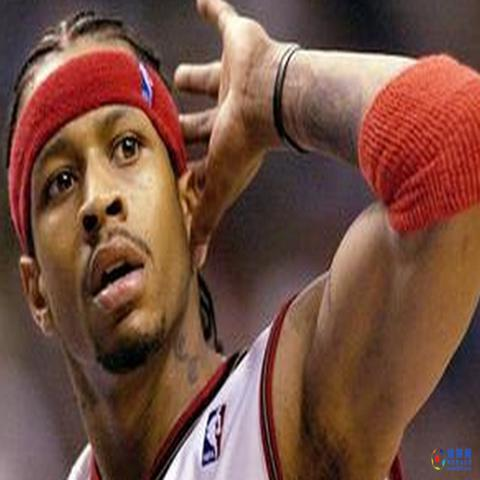

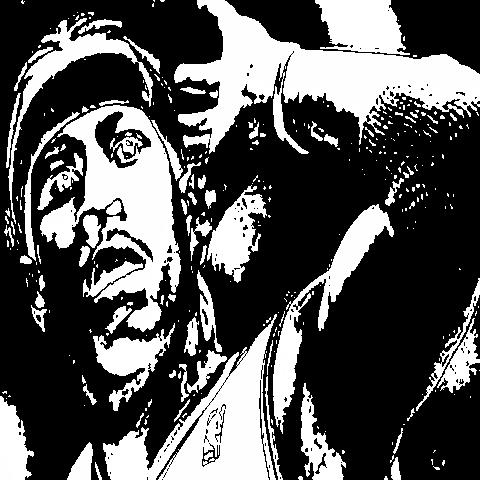

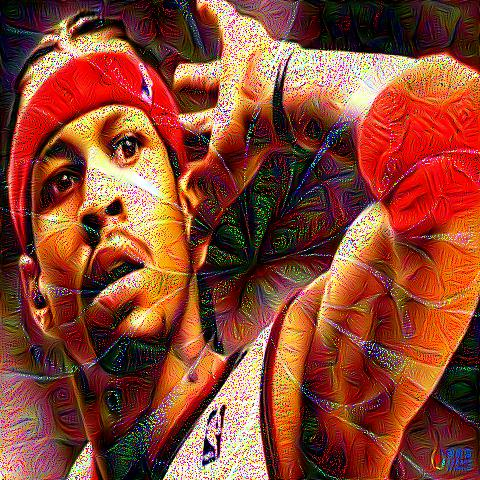

In [135]:
tgt_mask_func = partial(together_mask_func, func_list=[do_otsu, mask_stdmean_func])
_ = mix_mask_with_convd(tgt_mask_func, '../sample/lfs.jpg', '../prisma_gd/cx11.jpg', 
                        'conv2/norm2', enhance='Contrast', rb_rate=0.88, n2=180, n3=1,
                        convd_median_factor=0.01, convd_big_factor=0.0, show=True)

感觉不是很帅，那怎么行，前置一个Sharpness预处理效果，看看

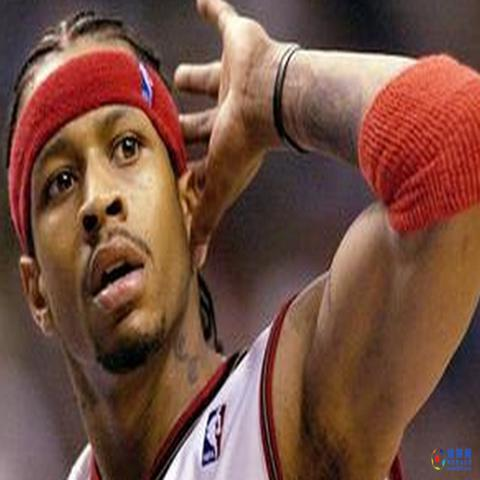

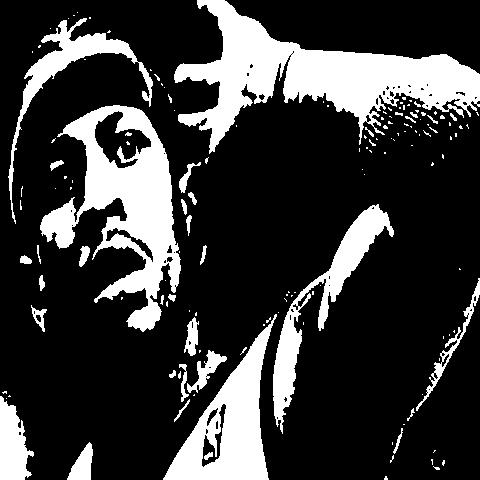

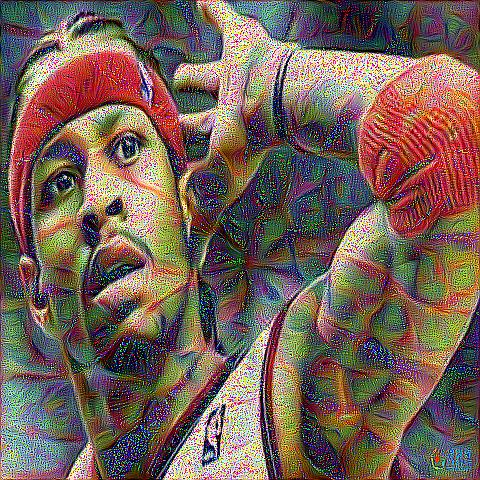

In [136]:
_ = mix_mask_with_convd(do_otsu, '../sample/lfs.jpg', '../prisma_gd/cx11.jpg', 'conv2/norm2', 
                        enhance='Sharpness', rb_rate=0.88, cb=False, n2=188, n3=1,
                        convd_median_factor=0.01, convd_big_factor=0.0, show=True)

上面两个作出的效果，仔细观察你会发现，其实他们并没有使用引导图的sharp特征，只是通过阶梯rgb渲染，在原始图像上泼上了一层浅层的edges特征，这样的话
实际上你不需使用上面这种实现方式，注意mix_mask_with_convd的参数all_mask，当all_mask为True时，将整个图像的mask全设置255，代码如下：

    clean_border_img = np.ones_like(l_img) * 255 if all_mask else do_mask_func(r_img=r_img, l_img=l_img, cb=cb)

所以如果要使用浅层特征edges直接设置all_mask就ok

### 6. 最终git上工程代码封装结构及使用示例

将上面的代码再次重构到文件PrismaWorker中, 代码详情请查阅PrismaWorker.py

In [4]:
from PrismaWorker import PrismaWorkerClass

In [5]:
pw = PrismaWorkerClass()

下面使用两个GTA5的图片，融合摩托车大哥到大部队中

如下为引导特征图

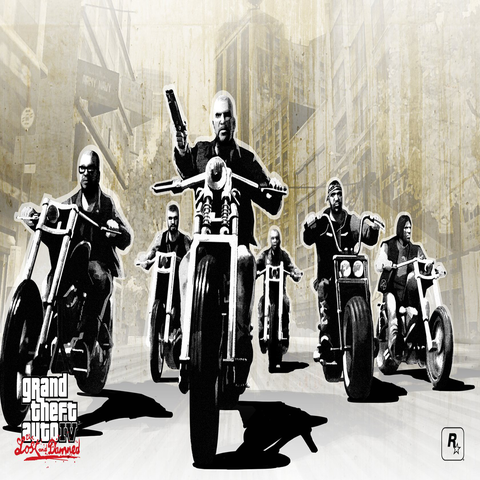

In [10]:
pw.cp.resize_img(PIL.Image.open('../prisma_gd/gta2.jpg'), base_width=480, keep_size=False)

注意partial(do_otsu, dd=False)中的dd参数代表otsu后取内部还是反向的外部，如下的黑白mask图，dd=False可以取到骑手，否则将取到外部背景

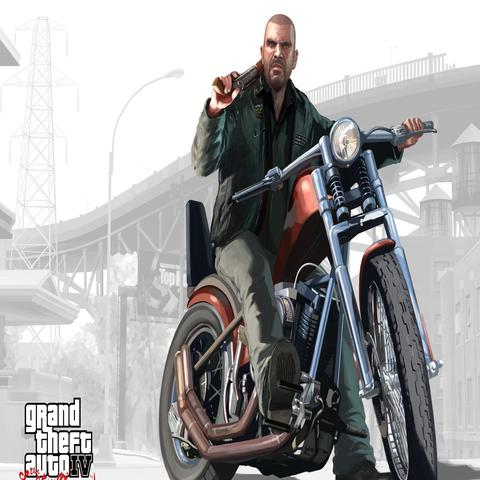

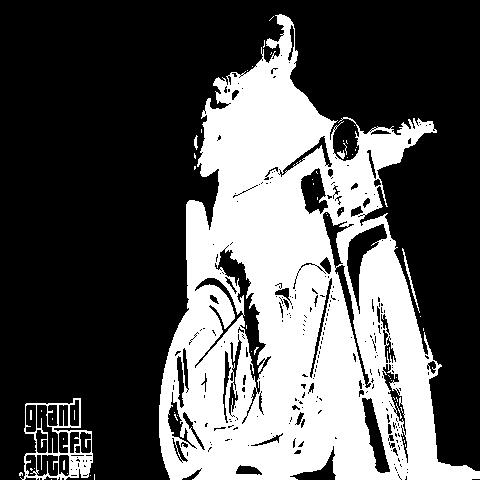

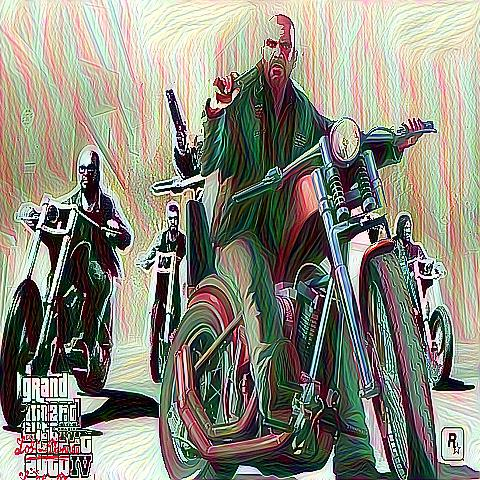

In [9]:
_ = pw.mix_mask_with_convd(partial(pw.do_otsu, dd=False), '../sample/gta4.jpg', '../prisma_gd/gta2.jpg', 'conv2/3x3_reduce', 
                           enhance='Sharpness',  n2=88, n3=1, 
                           convd_median_factor=1.5, convd_big_factor=0.0, show=True)

如上图所示，效果还算不错，除了左下脚两个标准的重叠

接下来使用批量处理引导图像，预处理，特征放大层等参数排列组合使用PrismaMaster，详情查询代码PrismaMaster.py

如下代码所示，可以生成所有参数排列组合的输出结果

In [ ]:
import PrismaMaster
cb=False
n1 = 5
n2=38
n3=1
convd_median_factor=0.6
convd_big_factor=0.0
loop_factor = 1.0
std_factor = 0.88

nbk_list = filter(lambda nbk: nbk[-8:-1] <> '_split_', cp.net.blobs.keys()[1:-2])[:10]
org_file_list = ['../sample/bz1.jpg']
gd_file_list = [None, '../cx/cx3.jpg', '../cx/cx6.jpg', '../cx/cx7.jpg','../cx/cx10.jpg']
enhance_list = [None, 'Sharpness', 'Contrast']
rb_rate_list = [0.85, 1.0]
    
save_dir = '../out/2016_11_24'
PrismaMaster.product_prisma(org_file_list, gd_file_list, nbk_list, enhance_list, rb_rate_list, 'otsu_func',
                            n1, n2, n3, std_factor, loop_factor, convd_median_factor, 
                            convd_median_factor, cb, save_dir)

输出的图像可以从中选择喜欢的，不必一个个的试效果了

![](../show/bz.jpg)

接下来再做一个gui的可视化操作界面PrismaController, 使用了traitsui库，详情查看了PrismaController.py

![](../show/gui.jpg)

基于这样一个方便微调的gui下可以很方便的对图像进行微调，非常容易的做出很多酷炫屌炸的图像，比如下面做的两张基于GTA风格的图像

![](../show/gta_cvt1.jpg)

![](../show/gta_cvt2.jpg)

上面这张犀利哥和GTA5合体的原图和引导特征图如下

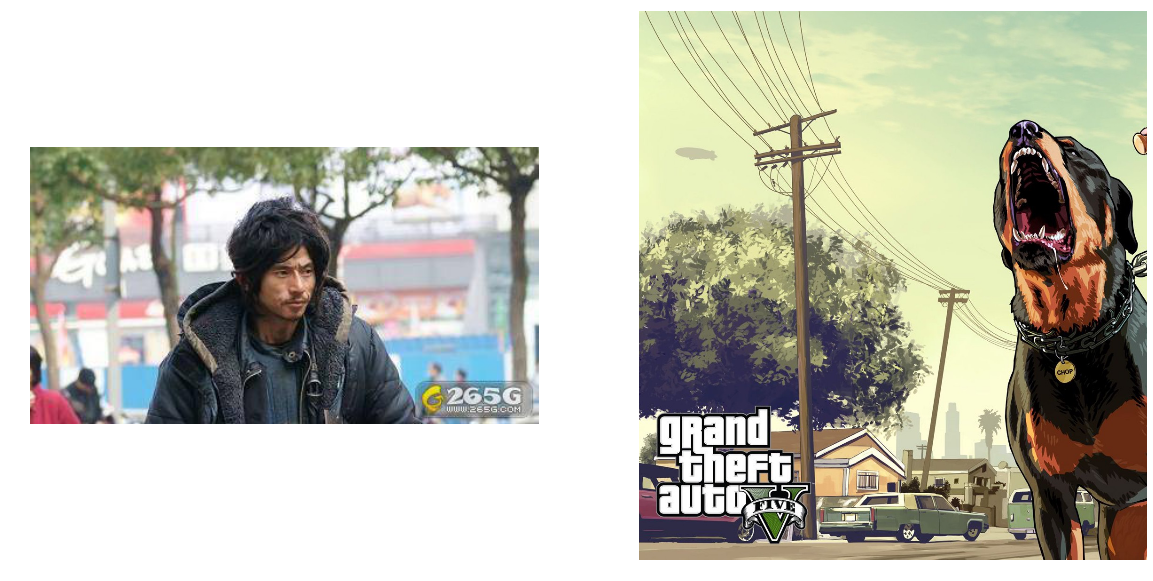

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10));
up_list = ['../sample/xlg.jpg', '../prisma_gd/gta1.jpg']
for ind, ax in zip(range(1 * 2), axs):
    iter_fn = up_list[ind]
    iter_img = plt.imread(iter_fn)
    # ax.set_title(os.path.basename(iter_fn))
    ax.imshow(iter_img);
    ax.set_axis_off()

如果你不知道什么样效果最好或者想要所有可能的效果图，你可以看到gui的界面上还有个按钮‘使用参数批量艺术图片’，它的作用是使用刚刚调整好的n1, n2, dd......等等参数作为固定参数，引导特征图，放大层特征，预处理增强等等作为所有可能的排列组合，通过一键生成几百上千张的风格图像，代码详情查看了PrismaController.py

    def _master_img_fired(self):
        nbk_list = ['conv2/3x3_reduce', 'conv2/3x3', 'conv2/norm2'] if g_use_min_batch_set else filter(
            lambda nbk: nbk[-8:-1] <> '_split_',
            self.prisma_worker.cp.net.blobs.keys()[1:-2])[:10]

        org_file_list = [self.org_file]

        gd_file_list = glob.glob('../prisma_gd/*.jpg')
        if g_use_min_batch_set:
            """
                小数据集只取 sm*.jpg
            """
            gd_file_list = filter(lambda fn: os.path.basename(fn).startswith('sm'), gd_file_list)
        # gd_file_list.insert(0, None)

        enhance_list = [None, 'Sharpness', 'Contrast'] if g_use_min_batch_set else [None, 'Sharpness', 'Contrast', 'CONTOUR']

        rb_rate_list = [1.0] if g_use_min_batch_set else [0.88, 1.0]

        # all_mask = self.all_mask
        all_mask = True

        save_dir = '../out/' + str(datetime.date.today())[:10]
        PrismaMaster.product_prisma(org_file_list, gd_file_list, nbk_list, enhance_list, rb_rate_list,
                                    self.mask_enum, self.n1_convd, self.n2_convd, self.n3_convd, self.dd,
                                    self.stdmean_func_factor, self.features_func_factor, self.convd_median_factor,
                                    self.convd_big_factor, self.cb, all_mask, save_dir)

本章后记：

1. 本文所讲的这种实现prisma的方式，不代表任何真实情况，只是一种可能的技术实现思路，并且在这种思路下还需要做很多的工作，比如针对适用性的问题也许要保存大量字典，字典的key可以是图像矩阵特征，value对应着处理参数，然后针对输入的图像进行分类或者特征相似度匹配来认定该使用那些参数等等复杂问题需要处理。

2. 本文git上的代码并没有过多关心代码运行效率等问题，比如针对图像保存，读取scipy.misc比用PIL的实现方式效率要高很多，但为了代码可读性，这里选择使用PIL

### 感谢🙏您能有耐心看到这里
### 如果有什么问题可以关注阿布的微信 
### 微信号：aaaabbbuu